<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/examples/multi_modal/gpt4v_multi_modal_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Multi-Modal Retrieval using GPT4V and Multi-Modal Index/Retriever

In this notebook, we show how to build a Multi-Modal retrieval system using LlamaIndex with GPT4V and CLIP.

LlamaIndex Multi-Modal Retrieval 
Text embedding index: Generate GPT text embeddings
Images embedding index: [CLIP](https://github.com/openai/CLIP) embeddings from OpenAI for images


Query encoder:
* Encoder query text for text index using GPT embedding
* Encoder query text for image index using CLIP embedding

Framework: [LlamaIndex](https://github.com/run-llama/llama_index)

Steps:
1. Using Multi-Modal LLM GPT4V class to undertand multiple images
2. Download texts, images, pdf raw files from related Wikipedia articles and SEC 10K report
2. Build Multi-Modal index and vetor store for both texts and images
4. Retrieve relevant text and image simultaneously using Multi-Modal Retriver according to the image reasoning from Step 1

In [ ]:
%pip install llama_index ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install -U qdrant_client

In [ ]:
import os

OPENAI_API_TOKEN = ""
os.environ["OPENAI_API_KEY"] = OPENAI_API_TOKEN

## Download images from Tesla website for GPT4V image reasoning

In [ ]:
from pathlib import Path

input_image_path = Path("input_images")
if not input_image_path.exists():
    Path.mkdir(input_image_path)

In [ ]:
!wget "https://docs.google.com/uc?export=download&id=1nUhsBRiSWxcVQv8t8Cvvro8HJZ88LCzj" -O ./input_images/long_range_spec.png
!wget "https://docs.google.com/uc?export=download&id=19pLwx0nVqsop7lo0ubUSYTzQfMtKJJtJ" -O ./input_images/model_y.png
!wget "https://docs.google.com/uc?export=download&id=1utu3iD9XEgR5Sb7PrbtMf1qw8T1WdNmF" -O ./input_images/performance_spec.png
!wget "https://docs.google.com/uc?export=download&id=1dpUakWMqaXR4Jjn1kHuZfB0pAXvjn2-i" -O ./input_images/price.png
!wget "https://docs.google.com/uc?export=download&id=1qNeT201QAesnAP5va1ty0Ky5Q_jKkguV" -O ./input_images/real_wheel_spec.png

## Generate image reasoning from GPT4V Multi-Modal LLM

### Plot input images

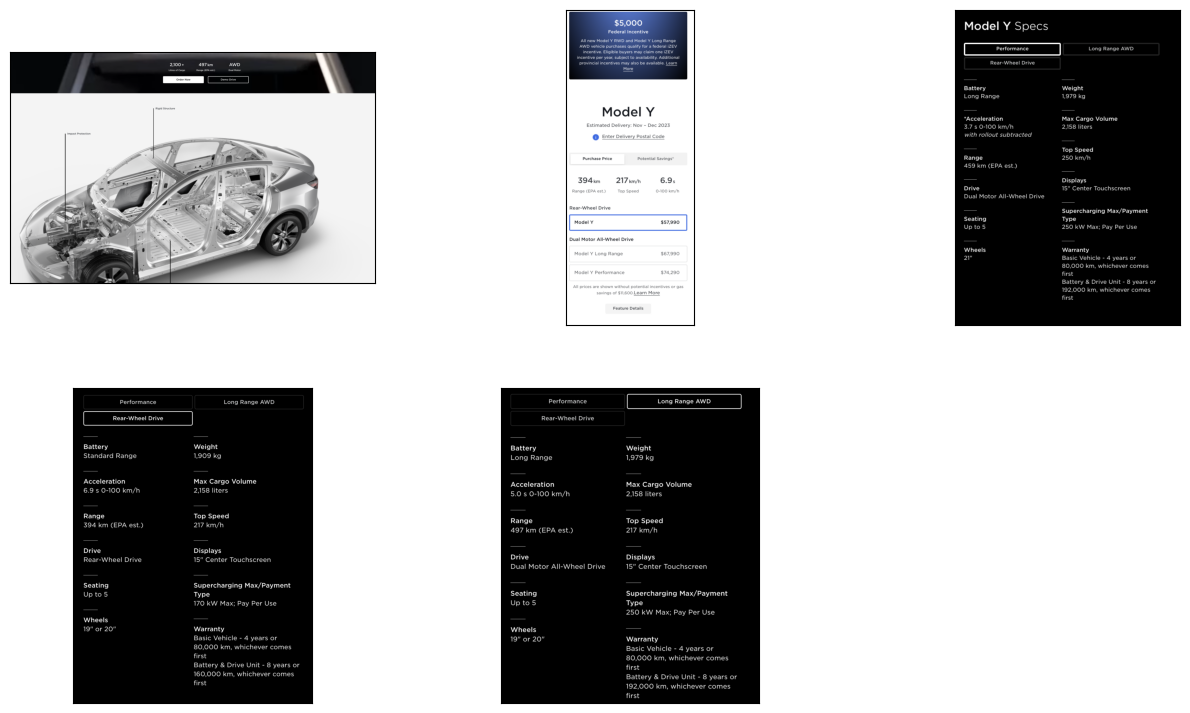

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir("./input_images"):
    image_paths.append(str(os.path.join("./input_images", img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


plot_images(image_paths)

### Using GPT4V to understand those input images

In [ ]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index import SimpleDirectoryReader

# put your local directore here
image_documents = SimpleDirectoryReader("./input_images").load_data()

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4-vision-preview", api_key=OPENAI_API_TOKEN, max_new_tokens=1500
)

response_1 = openai_mm_llm.complete(
    prompt="Describe the images as an alternative text",
    image_documents=image_documents,
)

print(response_1)

Image 1: This image shows a detailed comparison chart of specifications for two different versions of an electric vehicle categorized as "Performance" and "Long Range AWD". Each category includes stats such as Battery type, Acceleration (0-100 km/h), Range (EPA estimate), Top Speed, Drive Type, Seating, Wheels, and Warranty information.

Image 2: This is an image of a 3D cutaway illustration of an electric vehicle. The illustration highlights the car's rigid structure and impact protection zones. You can see the frame of the car, the positions of the battery packs, electric motors, and other structural elements without any body panels or interior features.

Image 3: This image displays the performance specs of the Model Y electric vehicle. It's set up in a comparison chart format showing details for the "Performance" and "Long Range AWD" model versions. It covers various specifications like Battery, Acceleration, Range (EPA estimate), Top Speed, Drive Type, Seating, Wheels, and Warrant

In [ ]:
response_2 = openai_mm_llm.complete(
    prompt="Can you tell me what is the price with each spec?",
    image_documents=image_documents,
)

print(response_2)

The images you've shared look like they are from an online configurator for an electric vehicle, given the specifications and warranty information provided. The last image displays pricing for different models of the vehicle. Here's the price breakdown based on the information in the image, alongside the presented specs for each respective model:

1. **Model Y Rear-Wheel Drive**
   - Battery: Long Range
   - Acceleration: 6.9 s 0-100 km/h
   - Range: 394 km (EPA est.)
   - Drive: Rear-Wheel Drive
   - Seating: Up to 5
   - Wheels: 19" or 20"
   - Warranty: Basic Vehicle - 4 years or 80,000 km, whichever comes first
   - **Price: $57,990**

2. **Model Y Dual Motor All-Wheel Drive**
   - Battery: Long Range
   - Acceleration: 5.0 s 0-100 km/h
   - Range: 497 km (EPA est.)
   - Drive: Dual Motor All-Wheel Drive
   - Seating: Up to 5
   - Wheels: 19" or 20"
   - Warranty: Basic Vehicle - 4 years or 80,000 km; Battery & Drive Unit - 8 years or 192,000 km, whichever comes first
   - **Price:

## Generating text, pdf, images data from raw files [Wikipedia, SEC files] for Multi Modal Index/Retrieval

In [ ]:
def get_wikipedia_images(title):
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "imageinfo",
            "iiprop": "url|dimensions|mime",
            "generator": "images",
            "gimlimit": "50",
        },
    ).json()
    image_urls = []
    for page in response["query"]["pages"].values():
        if page["imageinfo"][0]["url"].endswith(".jpg") or page["imageinfo"][
            0
        ]["url"].endswith(".png"):
            image_urls.append(page["imageinfo"][0]["url"])
    return image_urls

In [ ]:
from pathlib import Path
import requests
import urllib.request

image_uuid = 0
# image_metadata_dict stores images metadata including image uuid, filename and path
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 20

wiki_titles = {
    "Tesla Model Y",
    "Tesla Model X",
    "Tesla Model 3",
    "Tesla Model S",
    "Kia EV6",
    "BMW i3",
    "Audi e-tron",
    "Ford Mustang",
    "Porsche Taycan",
    "Rivian",
    "Polestar",
}


data_path = Path("mixed_wiki")
if not data_path.exists():
    Path.mkdir(data_path)

for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    with open(data_path / f"{title}.txt", "w") as fp:
        fp.write(wiki_text)

    images_per_wiki = 0
    try:
        # page_py = wikipedia.page(title)
        list_img_urls = get_wikipedia_images(title)
        # print(list_img_urls)

        for url in list_img_urls:
            if (
                url.endswith(".jpg")
                or url.endswith(".png")
                or url.endswith(".svg")
            ):
                image_uuid += 1
                # image_file_name = title + "_" + url.split("/")[-1]

                urllib.request.urlretrieve(
                    url, data_path / f"{image_uuid}.jpg"
                )
                images_per_wiki += 1
                # Limit the number of images downloaded per wiki page to 15
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        print(str(Exception("No images found for Wikipedia page: ")) + title)
        continue

In [ ]:
!wget "https://www.dropbox.com/scl/fi/mlaymdy1ni1ovyeykhhuk/tesla_2021_10k.htm?rlkey=qf9k4zn0ejrbm716j0gg7r802&dl=1" -O ./mixed_wiki/tesla_2021_10k.htm

## Build Multi-modal index and vector store to index both text and images

In [ ]:
from llama_index.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.vector_stores import QdrantVectorStore
from llama_index import SimpleDirectoryReader, StorageContext

import qdrant_client
from llama_index import (
    SimpleDirectoryReader,
)


# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_mm_db")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(vector_store=text_store)

# Create the MultiModal index
documents = SimpleDirectoryReader("./mixed_wiki/").load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents, storage_context=storage_context, image_vector_store=image_store
)

# Save it
# index.storage_context.persist(persist_dir="./storage")

# # Load it
# from llama_index import load_index_from_storage

# storage_context = StorageContext.from_defaults(
#     vector_store=text_store, persist_dir="./storage"
# )
# index = load_index_from_storage(storage_context, image_store=image_store)

/Users/haotianzhang/llama_index/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
print(response_2.text)

The images you've shared look like they are from an online configurator for an electric vehicle, given the specifications and warranty information provided. The last image displays pricing for different models of the vehicle. Here's the price breakdown based on the information in the image, alongside the presented specs for each respective model:

1. **Model Y Rear-Wheel Drive**
   - Battery: Long Range
   - Acceleration: 6.9 s 0-100 km/h
   - Range: 394 km (EPA est.)
   - Drive: Rear-Wheel Drive
   - Seating: Up to 5
   - Wheels: 19" or 20"
   - Warranty: Basic Vehicle - 4 years or 80,000 km, whichever comes first
   - **Price: $57,990**

2. **Model Y Dual Motor All-Wheel Drive**
   - Battery: Long Range
   - Acceleration: 5.0 s 0-100 km/h
   - Range: 497 km (EPA est.)
   - Drive: Dual Motor All-Wheel Drive
   - Seating: Up to 5
   - Wheels: 19" or 20"
   - Warranty: Basic Vehicle - 4 years or 80,000 km; Battery & Drive Unit - 8 years or 192,000 km, whichever comes first
   - **Price:

## Retrieve texts and image from MultiModal Index/Vector Store

In [ ]:
# generate Text retrieval results
MAX_TOKENS = 50
retriever_engine = index.as_retriever(
    similarity_top_k=3, image_similarity_top_k=3
)
# retrieve more information from the GPT4V response
retrieval_results = retriever_engine.retrieve(response_2.text[:MAX_TOKENS])

**Node ID:** 0e9c19f8-7e7f-4f82-8b27-cc4cb144371c<br>**Similarity:** 0.7076970827828022<br>**Text:** === Single-piece castings ===

In August 2020, it was reported that the Tesla Factory in Fremont would soon activate the world's largest unibody casting machine for Model Y production, switching to...<br>

**Node ID:** 23cd901d-07cf-48b9-9512-34120a6af0ae<br>**Similarity:** 0.704776817962228<br>**Text:** == Reception ==
Consumer Reports wrote that the all-wheel-drive Model X 90D largely disappoints, as rear doors are prone to pausing and stopping, the second-row seats that cannot be folded, and the...<br>

**Node ID:** cb63272d-8e37-45f6-bf97-cfff40aa72aa<br>**Similarity:** 0.7002743520600199<br>**Text:** The Tesla Model Y is a battery electric mid-size crossover SUV built by Tesla, Inc. since 2020.
The Model Y is based on the Model 3 sedan platform. It shares an estimated 75 percent of its parts wi...<br>

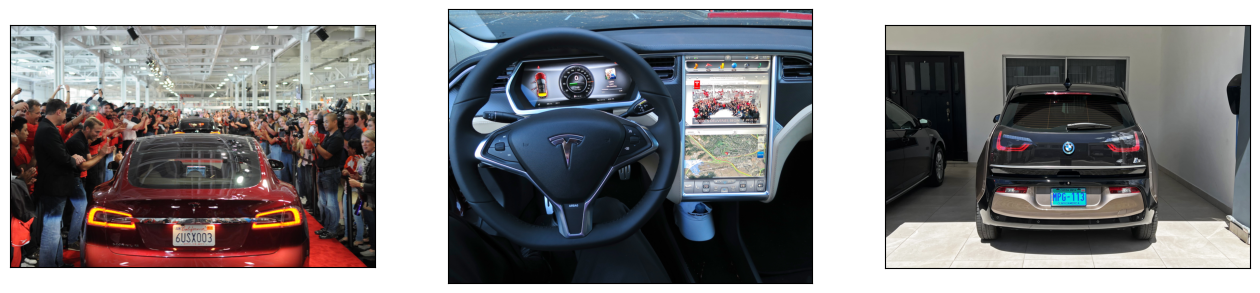

In [ ]:
from llama_index.response.notebook_utils import display_source_node
from llama_index.schema import ImageNode

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

In [ ]:
response_3 = openai_mm_llm.complete(
    prompt="what are other similar cars?",
    image_documents=image_documents,
)

print(response_3)

The images you've provided are related to the Tesla Model Y, as indicated by the text within the images and the specifications listed. 

When looking for cars similar to the Tesla Model Y, you are likely considering all-electric SUVs with similar range, performance, and technological features. Here are some vehicles that are comparable:

1. Audi e-tron – Audi's all-electric SUV offers a premium interior, advanced technology, and a range similar to the base Model Y.

2. Jaguar I-PACE – With sporty driving dynamics and a luxurious cabin, the I-Pace is a good alternative, offering competitive range and performance.

3. Ford Mustang Mach-E – Ford's entry into the electric SUV market offers a range of options, good performance, and a tech-focused cabin, much like the Model Y.

4. Volkswagen ID.4 – Volkswagen's electric SUV is aimed more at the mainstream market with a focus on comfort and practicality, and offers a good balance of range and features.

5. Chevrolet Bolt EUV – An electric uti